# NCF model

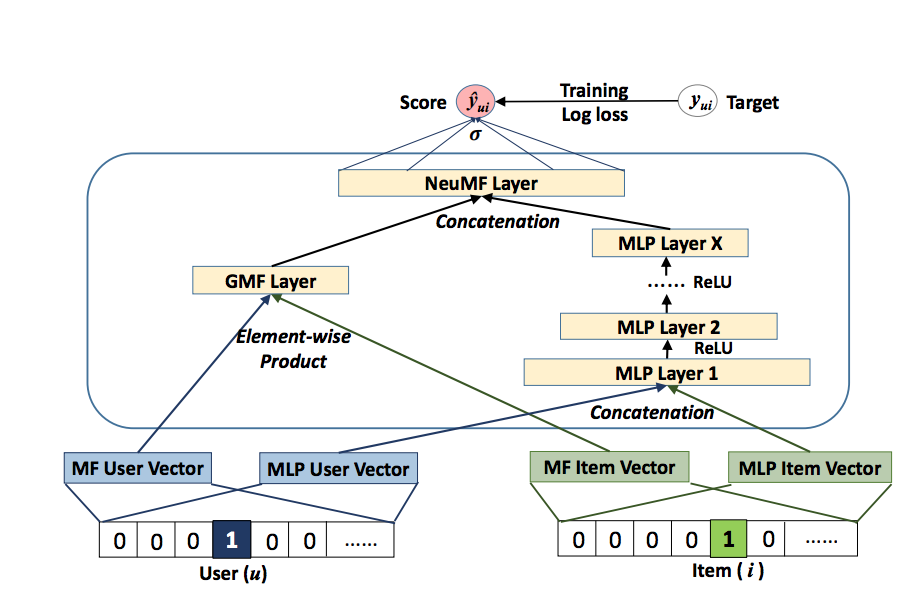

In [92]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Flatten, Multiply, Concatenate, Dropout, Dense, BatchNormalization
from tensorflow.keras.models import Model
import numpy as np
import heapq


In [104]:
# Defines the Neural Matrix Factorization model.
class NeuralMF:

    def __init__(self, user_num, item_num, id):

        latent_features = 32
        self.id = id
        # Input
        user = Input(shape=(1,), dtype='int32')
        item = Input(shape=(1,), dtype='int32')

        # User embedding for GMF
        gmf_user_embedding = Embedding(user_num, latent_features, input_length=user.shape[1], name="gmf_user_embedding_client_"+str(self.id))
        gmf_user_embedding_inp = gmf_user_embedding(user)
        gmf_user_embedding_inp = Flatten()(gmf_user_embedding_inp)

        # Item embedding for GMF
        gmf_item_embedding = Embedding(item_num, latent_features, input_length=item.shape[1], name="gmf_item_embedding_client_"+str(self.id))
        gmf_item_embedding_inp = gmf_item_embedding(item)
        gmf_item_embedding_inp = Flatten()(gmf_item_embedding_inp)

        # User embedding for MLP
        mlp_user_embedding = Embedding(user_num, latent_features, input_length=user.shape[1], name="mlp_user_embedding_client_"+str(self.id))
        mlp_user_embedding_inp = mlp_user_embedding(user)
        mlp_user_embedding_inp = Flatten()(mlp_user_embedding_inp)

        # Item embedding for MLP
        mlp_item_embedding = Embedding(item_num, latent_features, input_length=item.shape[1], name="mlp_item_embedding_client_"+str(self.id))
        mlp_item_embedding_inp = mlp_item_embedding(item)
        mlp_item_embedding_inp = Flatten()(mlp_item_embedding_inp)

        self.user_embedding_mlp = mlp_user_embedding
        self.user_embedding_gmf = gmf_user_embedding
        self.item_embedding_mlp = mlp_item_embedding
        self.item_embeddin_gmf = gmf_item_embedding
        
        # GMF layers
        gmf_mul =  Multiply()([gmf_user_embedding_inp, gmf_item_embedding_inp])

        # MLP layers
        mlp_concat = Concatenate()([mlp_user_embedding_inp, mlp_item_embedding_inp])
        mlp_dropout = Dropout(0.2)(mlp_concat)

        # Layer1
        mlp_layer_1 = Dense(units=64, activation='relu', name='mlp_layer1')(mlp_dropout)  # (64,1)
        mlp_dropout1 = Dropout(rate=0.2, name='dropout1')(mlp_layer_1)                    # (64,1)
        mlp_batch_norm1 = BatchNormalization(name='batch_norm1')(mlp_dropout1)            # (64,1)

        # Layer2
        mlp_layer_2 = Dense(units=32, activation='relu', name='mlp_layer2')(mlp_batch_norm1)  # (32,1)
        mlp_dropout2 = Dropout(rate=0.2, name='dropout2')(mlp_layer_2)                        # (32,1)
        mlp_batch_norm2 = BatchNormalization(name='batch_norm2')(mlp_dropout2)                # (32,1)

        # Layer3
        mlp_layer_3 = Dense(units=16, activation='relu', name='mlp_layer3')(mlp_batch_norm2)  # (16,1)

        # Layer4
        mlp_layer_4 = Dense(units=8, activation='relu', name='mlp_layer4')(mlp_layer_3)       # (8,1)

        # merge GMF + MLP
        merged_vector = tf.keras.layers.concatenate([gmf_mul, mlp_layer_4])

        # Output layer
        output_layer = Dense(1, kernel_initializer='lecun_uniform', name='output_layer', activation='sigmoid') # 1,1 / h(8,1)
        output_layer_out = output_layer(merged_vector)
        output_dummy = Dense(1, kernel_initializer='lecun_uniform', name='output_layer', activation='sigmoid')(mlp_layer_4)

        self.output = output_layer

        # Model
        self.model = Model([user, item], output_layer_out)
        self.mlp = Model([user, item], output_dummy)
        self.model.compile(optimizer= 'adam', loss= 'binary_crossentropy')

    def get_model(self):
        model = self.model
        return model

    def get_weights(self):
        mlp_wt = self.mlp.get_weights()
        item_mlp = self.item_embedding_mlp.get_weights()
        item_gmf = self.item_embeddin_gmf.get_weights()
        output = self.output.get_weights()
        wts = {
            "item_embedding_mlp": item_mlp,
            "item_embedding_gmf": item_gmf,
            "mlp": mlp_wt,
            "output": output
        }
        return wts

    def set_weights(self, weights):
        self.mlp.set_weights(weights['mlp'])
        self.output.set_weights(weights['output'])
        self.item_embedding_mlp.set_weights(weights['item_embedding_mlp'])
        self.item_embeddin_gmf.set_weights(weights['item_embedding_gmf'])

    def fit(self, user_data, item_data, labels, epochs, batch_size):
        self.model.fit([user_data, item_data], labels, epochs=epochs, batch_size=batch_size)


In [105]:

class Loader():

    def __init__(self):
        pass

    def load_dataset(self):
        
        df = pd.read_csv('./ratings.csv')
        df = df.drop(['timestamp'], axis=1)
        df.columns = ['user', 'item', 'rating']
        df = df.dropna()
        df = df.loc[df.rating != 0]


        df['count'] = df.groupby('user')['user'].transform('count')
        df = df[df['count'] > 1]

        
        df['user_id'] = df['user'].astype("category").cat.codes
        df['item_id'] = df['item'].astype("category").cat.codes

        # lookup 
        item_lookup = df[['item_id', 'item']].drop_duplicates()
        item_lookup['item_id'] = item_lookup.item_id.astype(str)

        # train, test 
        df = df[['user_id', 'item_id', 'rating']]
        

        # user, item 
        users = list(np.sort(df.user_id.unique()))
        items = list(np.sort(df.item_id.unique()))



        return df, items, users

    def get_samples(self, df, items):

        
        rows = df['user_id'].astype(int)
        cols = df['item_id'].astype(int)
        values = list(df.rating)

        uids = np.array(rows.tolist())
        iids = np.array(cols.tolist())

        df_neg = self.get_negatives(uids, iids, items, df)

        return uids, iids

    def get_negatives(self, uids, iids, items, df_test):
        
        negativeList = []
        test_u = df_test['user_id'].values.tolist()
        test_i = df_test['item_id'].values.tolist()

        test_ratings = list(zip(test_u, test_i))  # test (user, item)
        zipped = set(zip(uids, iids))             # train (user, item)

        for (u, i) in test_ratings:

            negatives = []
            negatives.append((u, i))
            for t in range(100):
                j = np.random.randint(len(items))     # neg_item j 1
                while (u, j) in zipped:              
                    j = np.random.randint(len(items))
                negatives.append(j)
            negativeList.append(negatives) # [(0,pos), neg, neg, ...]

        df_neg = pd.DataFrame(negativeList)

        return df_neg

    def mask_first(self, x):

        result = np.ones_like(x)
        result[0] = 0  # [0,1,1,....]

        return result

    def train_test_split(self, df):
        
        df_test = df.copy(deep=True)
        df_train = df.copy(deep=True)

        # df_test
        # user_id holdout_item_id(user)
        df_test = df_test.groupby(['user_id']).first()
        df_test['user_id'] = df_test.index
        df_test = df_test[['user_id', 'item_id', 'plays']]
        df_test = df_test.reset_index(drop=True)

        # df_train
        # user_id make_first()
        mask = df.groupby(['user_id'])['user_id'].transform(self.mask_first).astype(bool)
        df_train = df.loc[mask]

        return df_train, df_test

    def get_train_instances(self, uids, iids, num_neg, num_items):
        
        user_input, item_input, labels = [],[],[]
        zipped = set(zip(uids, iids)) # train (user, item) 

        for (u, i) in zip(uids, iids):

            # pos item 
            user_input.append(u)  # [u]
            item_input.append(i)  # [pos_i]
            labels.append(1)      # [1]

            # neg item 
            for t in range(num_neg):

                j = np.random.randint(num_items)      # neg_item j num_neg 
                while (u, j) in zipped:              
                    j = np.random.randint(num_items)  

                user_input.append(u)  # [u1, u1,  u1,  ...]
                item_input.append(j)  # [pos_i, neg_j1, neg_j2, ...]
                labels.append(0)      # [1, 0,  0,  ...]

        return user_input, item_input, labels

In [106]:
class Metric:

    def __init__(self):
        pass

    def get_hits(self, k_ranked, holdout):
        for item in k_ranked:
            if item == holdout:
                return 1
        return 0

    def eval_rating(self, idx, test_ratings, test_negatives, K, model):
        items = test_negatives[idx]      # negative items [neg_item_id, ... ] (1,100)
        user_idx = test_ratings[idx][0]  # [user_id, item_id][0]
        holdout = test_ratings[idx][1]   # [user_id, item_id][1]
        items.append(holdout)            # holdou[neg_item_id, ..., holdout] (1,101)

        # prediction
        predict_user = np.full(len(items), user_idx, dtype='int32').reshape(-1, 1)  # [[user_id], ...], (101, 1)
        np_items = np.array(items).reshape(-1, 1)                                   # [[item_id], ... ], (101, 1)

        predictions = model.predict([predict_user, np_items])
        predictions = predictions.flatten().tolist()
        item_to_pre_score = {item:pre for item, pre in zip(items, predictions)}

        k_ranked = heapq.nlargest(K, item_to_pre_score, key=item_to_pre_score.get)

        hits = self.get_hits(k_ranked, holdout)

        return hits

    def evaluate_top_k(self, df_neg, df_test, model, K=10):
        
        hits = []
        test_u = df_test['user_id'].values.tolist()
        test_i = df_test['item_id'].values.tolist()

        test_ratings = list(zip(test_u, test_i))
        df_neg = df_neg.drop(df_neg.columns[0], axis=1)
        test_negatives = df_neg.values.tolist()  # [[(user_id, item_id=holdout)], neg_item,... ] (1,100)

        sample_idx_lst = np.random.choice(len(test_ratings), int(len(test_ratings) * 0.3))
        for user_idx in sample_idx_lst:

            hitrate = self.eval_rating(user_idx, test_ratings, test_negatives, K, model)
            hits.append(hitrate)  # ex. [1,0,1,1,0,...] (1, df_test.shape[0])

        return hits

In [107]:
class Client:
    def __init__(
        self,
        data,
        epochs,
        batch_size,
        seed,
        id
    ):
        self.data = data
        self.epochs = epochs 
        self.batch_size = batch_size
        self.seed = seed
        self.id = id
        self._set_model()

    def _set_model(self):

        self.model = NeuMF(len(self.data['users']), len(self.data['items']), self.id)
        self.metric = Metric()


    def set_weights(self, weights):
        self.model.set_weights(weights)

    def get_weights(self):
        return self.model.get_weights()

    def get_data_size(self):
        return self.data['length']

    def fit(self, epochs, batch_size):
        
        self.model.fit(self.data['user_input'], self.data['item_input'], self.data['labels'], epochs, batch_size)
    
    def validate(self):
        import numpy as np
        hit_lst = self.metric.evaluate_top_k(self.data['df_neg'], self.data['df_test'], self.model.model, K=10)
        hit_rate = np.mean(hit_lst)
        print("Client hit rate: ", hit_rate)

    def print_user_embeddings(self):
        print("User Embedding GMF: \n")
        print(self.model.user_embedding_gmf.get_weights()[0][0])
        print("\n")

In [108]:

def ml_fedavg(client_wts, client_data_sizes):
    
    average_wts = {}
    fracs = []
    n = 0
    for size in client_data_sizes:
        n += size
    for size in client_data_sizes:
        fracs.append(size/n)

    #Averaging MLP weights
    average_weight_mlp=[]
    for index1 in range(len(client_wts[0]['mlp'])):
        layer_weights=[]
        for index2 in range(len(client_wts)):
            weights=client_wts[index2]['mlp'][index1]
            layer_weights.append(fracs[index2]*weights)
        average_weight=np.sum(np.array([x for x in layer_weights]), axis=0)
        average_weight_mlp.append(average_weight)

    #Averaging output layer weights
    average_weight_output = []
    for index1 in range(len(client_wts[0]['output'])):
        outputs = []
        for index2 in range(len(client_wts)):
            weights=client_wts[index2]['output'][index1]
            outputs.append(fracs[index2]*weights)
        average_output=np.sum(np.array([x for x in outputs]), axis=0)
        average_weight_output.append(average_output)

    #Averaging item embeddings for GMF
    average_item_profile_gmf = []
    for index1 in range(len(client_wts[0]['item_embedding_gmf'])):
        item_gmf = []
        for index2 in range(len(client_wts)):
            weights=client_wts[index2]['item_embedding_gmf'][index1]
            item_gmf.append(fracs[index2]*weights)
        average_item_gmf=np.sum(np.array([x for x in item_gmf]), axis=0)
        average_item_profile_gmf.append(average_item_gmf)

    #Averaging item embeddings for MLP
    average_item_profile_mlp = []
    for index1 in range(len(client_wts[0]['item_embedding_mlp'])):
        item_mlp = []
        for index2 in range(len(client_wts)):
            weights=client_wts[index2]['item_embedding_mlp'][index1]
            item_mlp.append(fracs[index2]*weights)
        average_item_mlp=np.sum(np.array([x for x in item_mlp]), axis=0)
        average_item_profile_mlp.append(average_item_mlp)


    average_wts['mlp'] = average_weight_mlp
    average_wts['output'] = average_weight_output
    average_wts['item_embedding_gmf'] = average_item_profile_gmf
    average_wts['item_embedding_mlp'] = average_item_profile_mlp
    
    return average_wts


In [109]:

def distribute_client_data(data, items, users, n_clients, loader, num_neg):
    sample_frac = 0.10
    test_frac = 0.04
    client_data = []
    for c in range(n_clients):
        r = np.random.random_sample()
        while r > 0.2:
            r = np.random.random_sample()
        sample = sample_frac + r
        df = data.sample(frac=sample, random_state=seed)
        length = df.shape[0]
        c_uids, c_iids = loader.get_samples(df, items)
        user_input, item_input, labels = loader.get_train_instances(c_uids, c_iids, num_neg, len(items))
        user_input = np.array(user_input).reshape(-1,1)
        item_input = np.array(item_input).reshape(-1,1)
        labels = np.array(labels).reshape(-1,1)

        df_test = data.sample(frac=test_frac, random_state=seed)
        test_uids, test_iids = loader.get_samples(df_test, items)
        df_test = df_test.groupby(['user_id']).first()
        df_test['user_id'] = df_test.index
        df_test = df_test[['user_id', 'item_id', 'rating']]
        df_test = df_test.reset_index(drop=True)
        df_neg = get_negatives(test_uids, test_iids, items, df_test)

        c_data = {
            'df': df,
            'items': items,
            'users': users,
            'uids': c_uids,
            'iids': c_iids,
            'user_input': user_input,
            'item_input': item_input,
            'labels': labels,
            'df_test': df_test,
            'df_neg': df_neg,
            'length': length
        }
        client_data.append(c_data)
    return client_data

In [110]:
def initialize_clients(client_data, weights, epochs, batch_size, seed):
    clients = []
    for i in range(len(client_data)):
        c_d = client_data[i]
        c = Client(c_d, epochs, batch_size, seed, i)
        c.set_weights(weights)
        clients.append(c)
    return clients        

In [111]:
def get_negatives(uids, iids, items, df_test):

        negativeList = []
        test_u = df_test['user_id'].values.tolist()
        test_i = df_test['item_id'].values.tolist()

        test_ratings = list(zip(test_u, test_i))  # test (user, item)
        zipped = set(zip(uids, iids))             # train (user, item)

        for (u, i) in test_ratings:

            negatives = []
            negatives.append((u, i))
            for t in range(100):
                j = np.random.randint(len(items))     # neg_item j 
                while (u, j) in zipped:              
                    j = np.random.randint(len(items))
                negatives.append(j)
            negativeList.append(negatives) # [(0,pos), neg, neg, ...]

        df_neg = pd.DataFrame(negativeList)

        return df_neg

In [112]:
def train_server(seed, epochs, batch_size, rounds, n_clients):


    num_neg=4
    loader = Loader()
    df, items, users = loader.load_dataset()

    server_df = df.sample(frac=0.2, random_state=seed)
    s_uids, s_iids = loader.get_samples(server_df, items)
    s_user_input, s_item_input, s_labels = loader.get_train_instances(s_uids, s_iids, num_neg, len(items))
    s_user_input = np.array(s_user_input).reshape(-1,1)
    s_item_input = np.array(s_item_input).reshape(-1,1)
    s_labels = np.array(s_labels).reshape(-1,1)

    df_test = server_df.copy(deep=True)
    df_test = df_test.groupby(['user_id']).first()
    df_test['user_id'] = df_test.index
    df_test = df_test[['user_id', 'item_id', 'rating']]
    df_test = df_test.reset_index(drop=True)

    df_neg = get_negatives(s_uids, s_iids, items, df_test)

    client_data = distribute_client_data(df, items, users, n_clients, loader, num_neg)
    
    server_model = NeuMF(len(users), len(items), "server")
    server_wt = server_model.get_weights()
    # server_model.set_weights(server_wt)
    # server_model.fit(s_user_input, s_item_input, s_labels, epochs, batch_size)
    
    clients = initialize_clients(client_data, server_wt, epochs, batch_size, seed)
    
    metric = Metric()

    hits = []
    for r in range(rounds):
        print("\n\n"+"="*30+" Starting round " + str(r+1)+" "+"="*30+"\n")
        client_wts = []
        client_data_sizes = []
        cid = 0

      

        for client in clients:
            print("="*15+" Training client " + str(cid)+" "+"="*15)
            client.set_weights(server_wt)     
            client.fit(epochs, batch_size)
            client_wts.append(client.get_weights())
            client_data_sizes.append(client.get_data_size())
            client.validate()
            cid += 1


        server_wt = ml_fedavg(client_wts, client_data_sizes)
        server_model.set_weights(server_wt)
        
        hit_lst = metric.evaluate_top_k(df_neg, df_test, server_model.model, K=10)
        hit = np.mean(hit_lst)

        hits.append(hit)
    
    return hits       

In [113]:
ml_datasize = '100k'
epochs = 1
batch_size = 128
seed = 42
n_clients = 2
rounds = 5

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

hits = train_server(seed, epochs, batch_size, rounds, n_clients)
print("Hits are as follows:")
with open('hit_rate.npy', 'wb') as f:
    np.save(f, hits)
f.close()



============================== Starting round 1 ==============================

=============== Training client 0 ===============
Train on 107155 samples
107155/107155 [==============================] - 3s 31us/sample - loss: 0.4583
Client hit rate:  0.6857142857142857
=============== Training client 1 ===============
Train on 72470 samples
72470/72470 [==============================] - 2s 34us/sample - loss: 0.4834
Client hit rate:  0.6628571428571428


============================== Starting round 2 ==============================

=============== Training client 0 ===============
Train on 107155 samples
107155/107155 [==============================] - 3s 24us/sample - loss: 0.3656
Client hit rate:  0.7657142857142857
=============== Training client 1 ===============
Train on 72470 samples
72470/72470 [==============================] - 2s 24us/sample - loss: 0.3691
Client hit rate:  0.7371428571428571


============================== Starting round 3 ==============================

